# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер. За дополнительные эксперименты с методами и их анализ можно получить бонусные баллы.

In [68]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [69]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [70]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балла).** Реализуйте метрику $MAP@k$.

In [71]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    aps = []
    for index_user, user in enumerate(predicted):
        p_i = 0

        for i_k in range(k):
            if user[i_k] in relevant[index_user]:
                p_i += np.isin(user[:i_k+1], relevant[index_user]).sum()/(i_k+1)
        aps.append(p_i/min(k, len(relevant[index_user])))

    MAP = sum(aps)/len(predicted)
    return MAP

In [72]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [73]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [74]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [75]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [76]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [77]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [78]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [79]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [80]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [81]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        for uid in range(self.n_users):
            test_preds += [self.recommend(uid)]
        test_preds = self.remove_train_items(test_preds, k)

        return test_preds[test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (0.5 балла).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [82]:
def s_p(user_vector, v):
    return v @ user_vector / (np.sqrt(v @ v * user_vector @ user_vector)) 

def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    return np.apply_along_axis(s_p, 1, ratings, user_vector)

def s(user_vector, v):
    return len(np.where((v > 0) & (user_vector > 0))[0])/len(np.where((v > 0) | (user_vector > 0))[0])

def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    return np.apply_along_axis(s, 1, ratings, user_vector)

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [83]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        simil = self.similarity(self.R[uid])
        n = np.where(simil > self.alpha)[0][np.where(simil > self.alpha)[0] != uid]
        res = simil[n] @ self.R[n]
        return np.argsort(-res)

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [84]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

In [85]:
import time 

In [86]:
start = time.time()
user2user_pearson = User2User(train_ratings, pearson)
rec_pearson = user2user_pearson.get_test_recommendations(50)
end = time.time() - start
print(end)

36.51175403594971


In [94]:
start = time.time()
user2user_jaccard = User2User(train_ratings, jaccard)
rec_jaccard = user2user_jaccard.get_test_recommendations(50)
end = time.time() - start
print(end)

7.683927059173584


In [95]:
rec_random = np.array(list(np.random.choice(ratings['trackId'].unique(), 50) for _ in test_users))

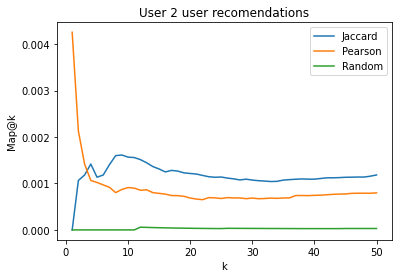

In [96]:
range_k = range(1, 50 + 1)
plt.plot(range_k, list(mapk(test_relevant, rec_jaccard, k) for k in range_k), label='Jaccard')
plt.plot(range_k, list(mapk(test_relevant, rec_pearson, k) for k in range_k), label='Pearson')
plt.plot(range_k, list(mapk(test_relevant, rec_random, k) for k in range_k), label='Random')
plt.ylabel('Map@k')
plt.xlabel('k')
plt.legend()
plt.title('User 2 user recomendations')
plt.show()

Как видим, рандомный способ имеет гораздо худшее качество, чем два других метода. Так, на небольших k (до примерно 5) лучше работает Пирсон, после k=5 лучшие результаты дает мера Жаккара, лучшее MAP на k от 10 до 20. 

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [99]:
# your code here: ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
from scipy.sparse import csr_matrix, find

def pearson_vector(v, user_vector):
    return (v @ user_vector.reshape(-1, 1) / (np.sqrt((v @ v.reshape(-1, 1)) * (user_vector @ user_vector.reshape(-1, 1))))).sum()

def pearson_sparse(ratings: csr_matrix, user_vector: csr_matrix):
    return np.apply_along_axis(pearson_vector, 1, ratings, user_vector)

def jaccard_vector(v, user_vector):
    return len(np.intersect1d(find(v)[1], find(user_vector)[1]))/len(find(v + user_vector > 0)[0])

def jaccard_sparse(ratings: csr_matrix, user_vector: csr_matrix):
    return np.apply_along_axis(jaccard_vector, 1, ratings, user_vector)


class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        simil = self.similarity(self.R[uid])
        n = np.where(simil > self.alpha)[0][np.where(simil > self.alpha)[0] != uid]
        res = simil[n] @ self.R[n]
        return np.argsort(-res)

class User2UserSparse(User2User):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings, similarity_func)
        self.R = csr_matrix(self.R)

In [100]:
start = time.time()
user2user_jaccard_sparse = User2UserSparse(train_ratings, jaccard_sparse)
rec_sparse_jaccard = user2user_jaccard_sparse.get_test_recommendations(50)
end = time.time() - start
print(end)

26.16072392463684


In [101]:
start = time.time()
user2user_pearson_sparse = User2UserSparse(train_ratings, pearson_sparse)
rec_sparse_pearson = user2user_pearson_sparse.get_test_recommendations(50)
end = time.time() - start
print(end)

63.57770109176636


Таким образом, время либо осталось тем же, либо увеличилось. 

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [102]:
model = User2User(train_ratings, pearson)

In [103]:
user_id = np.random.randint(0, model.n_users)

In [104]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
1360,Apologize,['OneRepublic']
2463,I'm Yours,['Jason Mraz']
2662,I Say a Little Prayer,['Aretha Franklin']
6034,Boogie Wonderland,"['Earth, Wind & Fire']"
6203,I Have Nothing,['Whitney Houston']
6262,Because of You,['Kelly Clarkson']
9834,Just One Last Dance,"['Sarah Connor', 'Natural']"
10016,Talking to the Moon,['Bruno Mars']
10893,La Seine,"['Vanessa Paradis', '-M-']"
13251,Tonight (Best You Ever Had),"['John Legend', 'Ludacris']"


In [105]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
18459,Take Me To Church,['Hozier']
35656,I Got Love,"['Miyagi & Эндшпиль', 'Рем Дигга']"
2481,Gangsta's Paradise,"['Coolio', 'L.V.']"
2814,Numb,['Linkin Park']
33436,Believer,['Imagine Dragons']
11950,Somebody That I Used To Know,"['Gotye', 'Kimbra']"
18914,Chandelier,['Sia']
39265,Beggin',['Måneskin']
35064,Thunder,['Imagine Dragons']
17240,The Monster,"['Eminem', 'Rihanna']"


In [106]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
61394,Мир сошёл с ума,['JONY']
61530,Твой поцелуй,"['Асия', 'NЮ']"
61560,Втюрилась,['Дора']
61584,Dynamite,['BTS']
61677,Если тебе будет грустно,"['Rauf & Faik', 'NILETTO']"
61820,Let's Love,"['David Guetta', 'Sia']"
61945,Diamonds,['Sam Smith']
62177,Courage to Change,['Sia']
62285,Coeur de pierre,['Slimane']
62348,Savage Love (Laxed - Siren Beat),"['Jawsh 685', 'Jason Derulo', 'BTS']"


Видно, что предсказания с переменным успехом соответсвуют предыдущим прослушанным трекам, стоит доработать модель. 

### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:**

$$L = \sum_{(u, i) \in R} (\langle p_u, q_i \rangle - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)$$

$$ \nabla_{p_u} L = 2\sum\limits_i q_i (\langle p_u, q_i \rangle - r_{ui}) + \lambda 2p_u = 2\sum\limits_i (q_i q_i^{T} p_u - r_{ui}q_i) + 2\lambda p_u $$

$$ \nabla_{q_i} L = 2\sum\limits_u p_u (\langle p_u, q_i \rangle - r_{ui}) + \lambda 2q_i = 2\sum\limits_u (p_u p_u^{T} q_i - r_{ui}p_u) + 2\lambda q_i $$

$$ p_{u new} = p_u + learning rate * \nabla_{p_u} L  = p_u + 2learning rate * (q_i q_i^{T} p_u - r_{ui}q_i + \lambda p_u)$$

$$ q_{i new} = q_i + learning rate * \nabla_{q_i} L  = q_i + 2learning rate * (p_u p_u^{T} q_i - r_{ui}p_u + \lambda q_i)$$

**ALS:**

Ответ

$$ \nabla_{p_u} L = 2\sum\limits_i (q_i q_i^{T} p_u - r_{ui}q_i) + 2\lambda p_u  = 0$$

$$\sum\limits_i (q_i q_i^{T} p_u - r_{ui}q_i) + \lambda p_u  = 0$$

$$\sum\limits_i (q_i q_i^{T}  + \lambda) p_u  = \sum\limits_i r_{ui}q_i$$

$$p_u = (\sum\limits_i q_i q_i^{T}  + \lambda)^{-1} \sum\limits_i r_{ui}q_i \forall u$$

$$P = (QQ^T + \lambda)^{-1}QR^T$$



$$ \nabla_{q_i} L = 2\sum\limits_u (p_u p_u^{T} q_i - r_{ui}p_u) + 2\lambda q_i = 0$$

$$\sum\limits_u (p_u p_u^{T} q_i - r_{ui}p_u) + \lambda q_i  = 0$$

$$\sum\limits_u (p_u p_u^{T}  + \lambda) q_i   = \sum\limits_u r_{ui}p_u$$

$$q_i  = (\sum\limits_u p_u p_u^{T}  + \lambda)^{-1} \sum\limits_u r_{ui}p_u \forall i$$

$$Q = (PP^T + \lambda)^{-1}PR$$



**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [107]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(dim, self.n_users))
        self.Q = np.random.normal(size=(dim, self.n_items))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                u = np.random.randint(0, self.n_users)
                i = np.random.randint(0, self.n_items)
                p = self.P[:, u]
                q = self.Q[:, i]
                self.P[:, u] = p - 2 * self.lr * (p @ q * q - self.R[u][i] * q + self.lamb * p)
                self.Q[:, i] = q - 2 * self.lr * (p @ q * p - self.R[u][i] * p + self.lamb * q)

            elif self.mode == 'als':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                self.P = np.linalg.inv(self.Q @ self.Q.T + self.lamb * np.eye(self.dim)) @ self.Q @ self.R.T
                self.Q = np.linalg.inv(self.P @ self.P.T + self.lamb * np.eye(self.dim)) @ self.P @ self.R

    def recommend(self, uid):
        pred_rating = self.Q.T @ self.P[:, uid]

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

In [130]:
for dim in [12, 32, 64, 128, 1000, 1024, 2048, 4096]:
    for iteration in [100, 500, 1000, 1500]:
        for k_glob in [10, 20, 30, 40, 50, 60]:
            model = HiddenVars(train_ratings, dim=dim, mode = 'sgd')

            model.fit(iteration)
            recs = model.get_test_recommendations(k_glob)
            best_mapk = 0
            for k in range(1, k_glob + 1):
                mapk_i = mapk(test_relevant, recs, k)
                if mapk_i > best_mapk:
                    best_mapk = mapk_i
                    best_dim = dim
                    best_iter = iteration
            best_k = k_glob
print(f'best params: dim = {best_dim}, num_iters = {best_iter}, k = {best_k}')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

best params: dim = 4096, num_iters = 1500, k = 50


In [136]:
for dim in [128, 564, 1024]:
    for iteration in [500, 1000, 1500]:
        model = HiddenVars(train_ratings, dim=dim, mode = 'als')

        model.fit(iteration)
        recs = model.get_test_recommendations(50)
        best_mapk = 0
        
        mapk_i = mapk(test_relevant, recs, 50)
        if mapk_i > best_mapk:
            best_mapk = mapk_i
            best_dim = dim
            best_iter = iteration


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [137]:
print(f'best params: dim = {best_dim}, num_iters = {best_iter}')

best params: dim = 564, num_iters = 500


In [138]:
model_sgd = HiddenVars(train_ratings, dim=4096, mode = 'sgd')
model_sgd.fit(1500)
model_als = HiddenVars(train_ratings, dim=564, mode = 'als')
model_als.fit(500)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [139]:
rec_sgd = model_sgd.get_test_recommendations(50)
rec_als = model_als.get_test_recommendations(50)

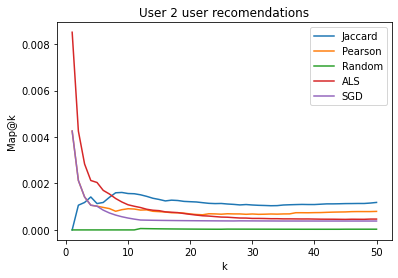

In [140]:
range_k = range(1, 50 + 1)
plt.plot(range_k, list(mapk(test_relevant, rec_jaccard, k) for k in range_k), label='Jaccard')
plt.plot(range_k, list(mapk(test_relevant, rec_pearson, k) for k in range_k), label='Pearson')
plt.plot(range_k, list(mapk(test_relevant, rec_random, k) for k in range_k), label='Random')
plt.plot(range_k, list(mapk(test_relevant, rec_als, k) for k in range_k), label='ALS')
plt.plot(range_k, list(mapk(test_relevant, rec_sgd, k) for k in range_k), label='SGD')
plt.ylabel('Map@k')
plt.xlabel('k')
plt.legend()
plt.title('User 2 user recomendations')
plt.show()

Таким образом, после отдельного подбора гиперпараметров для каждой модели лучшим алгоритмом на небольшом k является ALS, он выдает наибольшее МАР и лучше всего подстраивается под данные. Также большее количество итераций позволяет выдавать более подходящие рекомендации. 

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [141]:
model = model_als

In [142]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q.T @ model.Q[:, example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=0) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [143]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[:, example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.568395
5515,Романс,['Сплин'],0.505726
17328,Я хочу быть с тобой,['Nautilus Pompilius'],0.486872
17331,"Последнее письмо (Гудбай, Америка)",['Nautilus Pompilius'],0.478669
2179,Восьмиклассница,['КИНО'],0.447108
26075,Лошадка,['Найк Борзов'],0.445331
5153,Stormbringer,['Deep Purple'],0.441359
9689,Bicycle Race,['Queen'],0.441359
16637,Zodiac,['Zodiac'],0.441359
